# Regression Modelling by Date

In [22]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import random
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [29]:
stations = pd.read_csv("../CSVFiles/stations.csv").drop(columns=["Unnamed: 0"])
stations.head()

max_cluster = [2, 3, 5, 7, 8, 9, 10, 27, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 42]
min_cluster = [1, 4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 34]

In [30]:
trips = pd.read_csv("../CSVFiles/tripsStationHour.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
working_day = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    working_day.append(0 if date.tm_wday >= 5 else 1)
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips["Day"] = day
trips["Year"] = year
trips["WorkingDay"] = working_day
trips = trips.drop(columns=["DateEnd"])

dataset = trips.loc[trips["StationEnd"].isin(min_cluster)]
dataset.head()

,Hour,StationEnd,Count,Day,Year,WorkingDay
0,0,26,1,1,2011,0
1,0,17,1,1,2011,0
13,1,21,1,1,2011,0
16,1,19,1,1,2011,0
21,1,13,1,1,2011,0


## Regression

In [31]:
mse_array = []
accuracy_array = []

first_hour = dataset.values[0][0]
first_day = dataset.values[0][3]
first_year = dataset.values[0][4]

### Method 1
Input: c(t)

Output: c(t+1)

In [32]:
X = dataset.drop(columns=["Count", "Year", "Day"])
y = dataset["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring="neg_mean_squared_error", groups=dataset["WorkingDay"])

mse = abs(scores.mean())
stdAccuracy = scores.std()
print(f"Mean Absolute Error: {mse}, Standard Deviation : {stdAccuracy}")

mse_array.append(mse)
accuracy_array.append(stdAccuracy)

Mean Absolute Error: 6.230588701825763, Standard Deviation : 2.56457768907259


### Method 2
Input: c(t), c(t-1)

Output: c(t+1)

In [33]:
count_met2 = 0
cnt = []
for trip in dataset.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if hour == first_hour and year == first_year and day == first_day:
        count_met2 += 1
        continue

    hour -= 1
    if hour == -1:
        hour = 23
        day -= 1

    df = dataset.loc[(dataset["Hour"] == hour) & (dataset["Day"] == day) & (dataset["Year"] == year) & (dataset["StationEnd"] == station)]

    if df.empty:
        cnt.append(0)
    else:
        cnt.append(df.values[0][2])

dataset_method2 = dataset[count_met2:].copy()
dataset_method2["Count1"] = cnt

X = dataset_method2.drop(columns=["Count", "Year", "Day"])
y = dataset_method2["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring="neg_mean_squared_error", groups=dataset_method2["WorkingDay"])

mse = abs(scores.mean())
stdAccuracy = scores.std()
print(f"Mean Absolute Error: {mse}, Standard Deviation : {stdAccuracy}")

mse_array.append(mse)
accuracy_array.append(stdAccuracy)

Mean Absolute Error: 4.585131834462295, Standard Deviation : 1.7228092294967339


### Method 3
Input: c(t), c(t-1), c(t-1semana)

Output: c(t+1)

In [34]:
count_met3 = 0
cnt = []
for trip in dataset.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 7:
        count_met3 += 1
        continue

    day -= 7

    df = dataset.loc[(dataset["Hour"] == hour) & (dataset["Day"] == day) & (dataset["Year"] == year) & (dataset["StationEnd"] == station)]

    if df.empty:
        cnt.append(0)
    else:
        cnt.append(df.values[0][2])

dataset_method3 = dataset_method2[count_met3-count_met2:].copy()
dataset_method3["Count1week"] = cnt

X = dataset_method3.drop(columns=["Count", "Year", "Day"])
y = dataset_method3["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring="neg_mean_squared_error", groups=dataset_method3["WorkingDay"])

mse = abs(scores.mean())
stdAccuracy = scores.std()
print(f"Mean Absolute Error: {mse}, Standard Deviation : {stdAccuracy}")

mse_array.append(mse)
accuracy_array.append(stdAccuracy)

Mean Absolute Error: 4.231267598303932, Standard Deviation : 1.206924628404073


### Method 4
Input: c(t), c(t-1), c(t-1semana), c(t-2semana)

Output: c(t+1)

In [35]:
count_met4 = 0
cnt = []
for trip in dataset.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 14:
        count_met4 += 1
        continue

    day -= 14

    df = dataset.loc[(dataset["Hour"] == hour) & (dataset["Day"] == day) & (dataset["Year"] == year) & (dataset["StationEnd"] == station)]

    if df.empty:
        cnt.append(0)
    else:
        cnt.append(df.values[0][2])

dataset_method4 = dataset_method3[count_met4-count_met3:].copy()
dataset_method4["Count2week"] = cnt

X = dataset_method4.drop(columns=["Count", "Year", "Day"])
y = dataset_method4["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring="neg_mean_squared_error", groups=dataset_method4["WorkingDay"])

mse = abs(scores.mean())
stdAccuracy = scores.std()
print(f"Mean Absolute Error: {mse}, Standard Deviation : {stdAccuracy}")

mse_array.append(mse)
accuracy_array.append(stdAccuracy)

Mean Absolute Error: 4.066889801470978, Standard Deviation : 0.9791224713380987


### Method 5
Input: c(t), c(t-1), c(t-1semana), c(t-2semana), c(t-3semana)

Output: c(t+1)

In [36]:
count_met5 = 0
cnt = []
for trip in dataset.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 21:
        count_met5 += 1
        continue

    day -= 21

    df = dataset.loc[(dataset["Hour"] == hour) & (dataset["Day"] == day) & (dataset["Year"] == year) & (dataset["StationEnd"] == station)]

    if df.empty:
        cnt.append(0)
    else:
        cnt.append(df.values[0][2])

dataset_method5 = dataset_method4[count_met5-count_met4:].copy()
dataset_method5["Count3week"] = cnt

X = dataset_method5.drop(columns=["Count", "Year", "Day"])
y = dataset_method5["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring="neg_mean_squared_error", groups=dataset_method5["WorkingDay"])

mse = abs(scores.mean())
stdAccuracy = scores.std()
print(f"Mean Absolute Error: {mse}, Standard Deviation : {stdAccuracy}")

mse_array.append(mse)
accuracy_array.append(stdAccuracy)

Mean Absolute Error: 3.9876557741635343, Standard Deviation : 0.8645041311085455


### Method 6
Input: c(t), c(t-1), c(t-1semana), c(t-2semana), c(t-3semana), c(t-4semana)

Output: c(t+1)

In [37]:
count_met6 = 0
cnt = []
for trip in dataset.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 28:
        count_met6 += 1
        continue

    day -= 28

    df = dataset.loc[(dataset["Hour"] == hour) & (dataset["Day"] == day) & (dataset["Year"] == year) & (dataset["StationEnd"] == station)]

    if df.empty:
        cnt.append(0)
    else:
        cnt.append(df.values[0][2])

dataset_method6 = dataset_method5[count_met6-count_met5:].copy()
dataset_method6["Count4week"] = cnt

X = dataset_method6.drop(columns=["Count", "Year", "Day"])
y = dataset_method6["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring="neg_mean_squared_error", groups=dataset_method6["WorkingDay"])

mse = abs(scores.mean())
stdAccuracy = scores.std()
print(f"Mean Absolute Error: {mse}, Standard Deviation : {stdAccuracy}")

mse_array.append(mse)
accuracy_array.append(stdAccuracy)

Mean Absolute Error: 3.962690897111892, Standard Deviation : 0.7741315481632045


## Graphs

Text(0.5, 0, 'Methods')

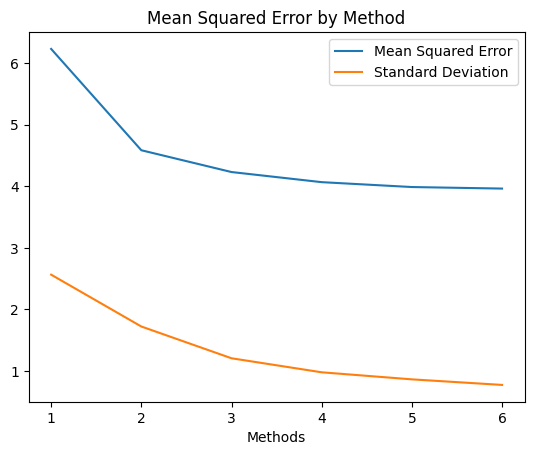

In [38]:
plt.plot(list(range(1,len(mse_array)+1)), mse_array)
plt.plot(list(range(1,len(accuracy_array)+1)), accuracy_array)
plt.legend(["Mean Squared Error", "Standard Deviation"])
plt.title("Mean Squared Error by Method")
plt.xlabel("Methods")

In [40]:
dataset_method5.to_csv("../DateDatasets/dataset.csv")